# Fanal

## A neutrino-less beta decay experiment 

## An open exercise

## Background estimation 


### USC, Master de Física, Física de Partícula II


J. A. Hernando-Morata, with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz.

February 2021


In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats     as stats  # statistics and Many PDFs 
#import scipy.optimize  as optimize # Minimice funtions

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD THE FOLDER TO PYTHONPATH
import os
import sys
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext as pltext
import core.efit   as efit # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils  as ut

import ana.fanal  as fn

pltext.style()

## Indications

### Objective

**Estimate the background contamination**, the number of Bi and Tl events, using blind-data.

### Tasks


   * Open the data file (HDF) and access the mock calibration blind-data (calb).
   
   * Estimate the number of Bi, Tl events in your blind-data.
   
     * Fit the energy distribution to a combination of energy distributions of Bi and Tl obtained from MC.
              
   * Test that the data-blind distributions are as expected according to MC. 
   
   * Estimate the background index in your RoI

## Notes


A **blind analysis** is an analysis in which the data in a region of interest is blind or masked during the analysis. 

The analysis must be first completely defined, the procedures and methods verified, before analyzing the complete data set. 

A blind-analysis tries to avoid a human bias.


## Notes


In this exercise we need to estimate the number of background events in a blind-data set.

Blind data are those events in which the main track, track0_E, has an energy between 2.42 and 2.52 MeV. 

In order to estimate the number of bkg events in the data, we use here the total energy of the event. 

We fit the energy distribution of the blind data to a composite sample, which is a weighted distribution of the energy distributions obtained with the MC samples, from which we previously removed events in the blind region.


### An etended likelihood fit

We generate the PDF of a variable (energy) for each mc sample, and define later a combined PDF, $f(x | {\bf n})$ with parameters are ${\bf n} = (n_{bb}, n_{Bi}, n_{Tl})$ the number of events in each sample. 

$$
f(x | {\bf n}) = \sum_i \frac{n_i}{n} \, f_i(x)
$$

where $i$ is the index of each sample, $(bb0nu,\, Bi, \, Tl)$;  $f_i(x)$ the PDF of sample $i$ and $n = \sum_i n_i$

We then compute the likelihood of our sample, $\mathcal{L}({\bf x} | {\bf n}) = \Pi_{i=1}^m f(x_i | {\bf n})$ 
and minimize $- 2 \log \mathcal{L}({\bf x} | {\bf n})$.



An Extended Likelihood includes also the factor of the probability of observing $m$ events expecting $n$.

The total likelihood is:

$$
\mathcal{L}_{ext}({\bf x} | {\bf n}) = g(m | n) \; \Pi_{i=1}^m f(x_i | {\bf n})
$$

where $g(m|n)$ is the poisson PDF with mean $n$.



## Recomendations

Generate the MC PDFs for the different samples and construct the combined PDF. 

You can create a PDF from a histogram (see [scipy stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_histogram.html)). 

Validate your fit with random experiments.

In the guide there is an example of an Extended Maximum Likelihood method.




## Access the data

In [5]:
#dirpath = '/Users/hernando/docencia/master/Fisica_Particulas/USC-Fanal/data/'

In [6]:
filename = 'alpha.h5'
print('Data path and filename : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

datab = pd.read_hdf(dirpath + filename, key = 'data/blind')

Data path and filename :  /Users/hernando/docencia/master/Fisica_Particulas/USC-Fanal/data/eta.h5


### Utilities

In [7]:
samples  = ['bb0nu', 'Bi', 'Tl']
ssamples = [r'$\beta\beta0\nu$', r'$^{214}$Bi', r'$^{208}$Tl']
mcs      = [mcbb, mcbi, mctl]

In [8]:
erange     = (2.4, 2.65)
evar       = 'E'

## Inspect the variables

In [9]:
#pltext.df_inspect(datab, ncolumns = 3)

## Energy distribution of the blind-data

Plot the energy distribution of the blind-data

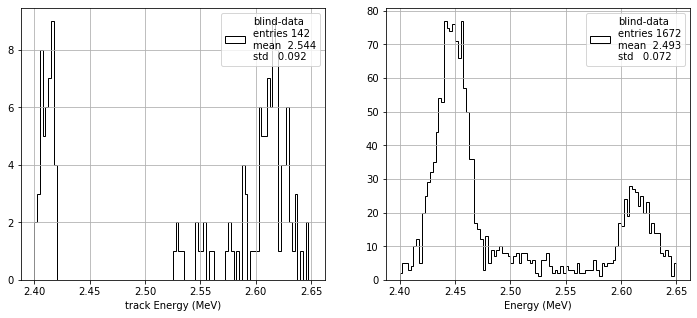

In [10]:
def plt_energy(df, label = '', bins = 100, erange = erange):

    subplot = pltext.canvas(1)

    subplot(1)
    pltext.hist(df.track0_E, bins, range = erange, label = label)
    plt.xlabel('track Energy (MeV)')

    subplot(2)
    pltext.hist(df.E, bins, range = erange, label = label)
    plt.xlabel('Energy (MeV)');
    
plt_energy(datab, 'blind-data')

## Estimate the number of background events in the blind-data

Remove from the MC the events in the blind region. 

Obtain the PDFs distribution for a reference variable, i.e. dnergy, for each sample; and generate a combined PDF where the parameters are the number of events of each sample.

Fit the distribution of that variable to a combined PDF and to estimate the number of background events, Bi, Tl.

Compute the total number of background events in the sample and the events in the RoI. 

### Generate MC-blind samples

Generate MC sample without events in the blind region

Plot the energy

In [11]:
mcs_blind = []
blindvar   = 'track0_E'
blindrange = (2.420, 2.520)
for mc in mcs:
    # select the complementary evnets 
    # (use of the symbol '~' to get the complementary)
    sel = ~ut.selection(mc, blindvar, blindrange)
    mcs_blind.append(mc[sel])

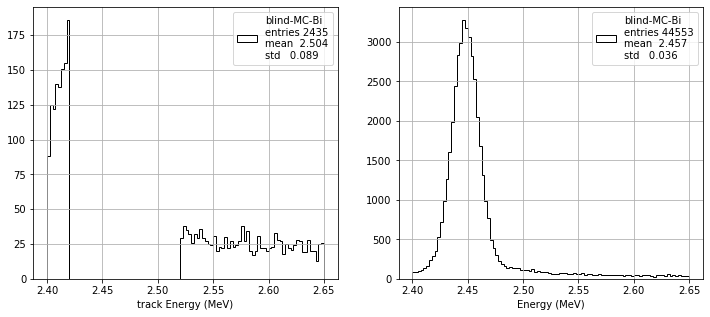

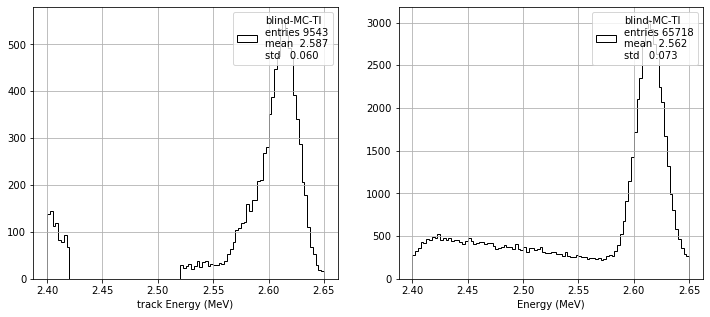

In [12]:
plt_energy(mcs_blind[1], 'blind-MC-Bi')
plt_energy(mcs_blind[2], 'blind-MC-Tl')

### An example of how to generate PDFs from histograms

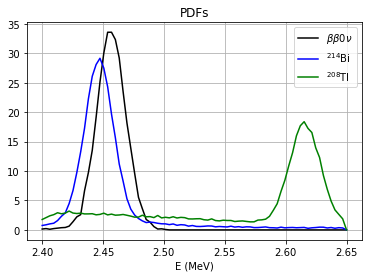

In [13]:
bins = 80
# generate the PDFs of the mcsblind DFs making histograms
pdfs = []
varname  = 'E' 
varrange = erange
for mc in mcs_blind[:]:
    histo = np.histogram(mc[varname], bins, range = varrange);
    pdf = stats.rv_histogram( histo )
    pdfs.append(pdf)

xs   = np.linspace(*varrange, bins)
for i, pdf in enumerate(pdfs): 
    plt.plot(xs, pdf.pdf(xs), label = ssamples[i])
plt.grid(); plt.legend(); 
plt.xlabel('E (MeV)'); plt.title('PDFs');

### Generate a random experiment using combined pdfs and do a fit

Construct an 'Extended Combined PDF' object (see class ExtComPDF in module efit.py). 

This object can generate random events (*rvs* method), provides the PDF (*pdf* method), the extended log likelihood (*loglike*) and even the fit to a best estimate (*best_estimate*).

Internally it uses the module *optimize* of *scipy* ([see](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)). 

Here an example with our previously construced PDFs of each sample.

Fit  True , parameters  [  14.04688847  954.16255052 2032.85010368]


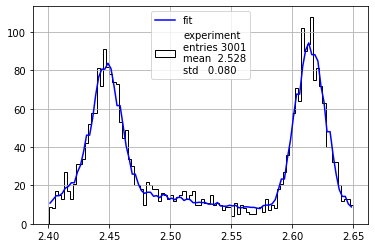

In [14]:
## generate the combined PDF 
ns  = (10., 1000., 2000.) # number of events of each sample
ell = efit.ExtComPDF(pdfs, *ns)

# generate a random experiment
xs  = ell.rvs()
# plot the random events
_, edges, _ = pltext.hist(xs, 100, label = 'experiment');

# fit using the Extended Log Likelihood
res = ell.best_estimate(xs, *ns)
# access the information of the 'res' Result Object (see )
print('Fit ', res.success, ', parameters ', res.x)

# overplot the fit result
ns_est  = res.x
centers = 0.5 * (edges[1:] + edges[:-1])
scale   = np.sum(ns_est) * (edges[1] - edges[0])
pdf     = ell.pdf # access to the pdf function inside the composite-PDF object
plt.plot(centers, scale * pdf(centers, *ns_est), label = 'fit')
plt.legend();

## Fit blind-data using an Extended Likelihood Fit

Now we fit the blind-data to an Entended Likelihood fit.

The code is in the module *fanal* in the function *fit_ell*.

number of events :   0.00, 1090.80, 581.18,


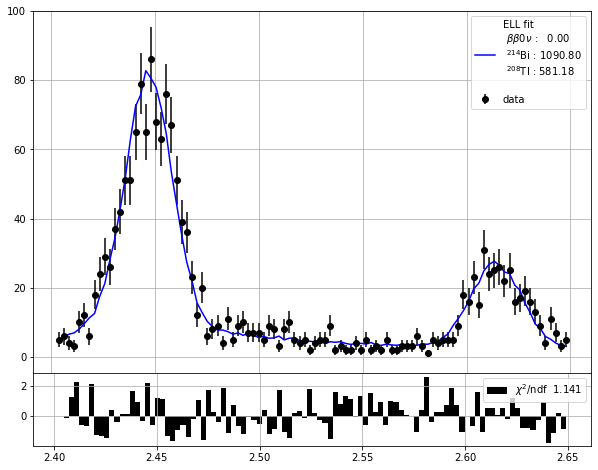

In [16]:
ns       = (0., 2200., 5200.) # initial guess of the number of events in the blind sample
bins     = 100
varname  = 'E'
varrange = erange
# fit_ell internally generates the composite pdf, calls the fit and returns the fit-result
result, ene, ell = fn.fit_ell(datab, mcs_blind, ns, varname, bins, varrange)
ns_est = result.x
print('number of events :', *['{:6.2f},'.format(ni) for ni in ns_est])
# it also plots the histogram and the fit function
fn.plot_fit_ell(ene, ns_est, ell.pdf)

*TODO*: Compute the parameters uncertainties

## Compute the total number of background events

In [17]:
effs_erange = [] 
effs_total  = []
for mc in [mcbb, mcbi, mctl]:
    eeff = ut.efficiency(ut.selection(mc, 'E'     , erange))[0]
    beff = ut.efficiency(ut.selection(mc, blindvar, blindrange))[0]
    eff = eeff * (1 - beff)
    effs_erange.append(eeff)
    effs_total .append(eff)

names   = ['bb0nu', 'Bi', 'Tl']
nblinds = [ni / eff for ni, eff in zip(ns_est, effs_erange)]
print('Total Blind events :', *['{:s} \t {:6.2f},'.format(s, ni) for s, ni in zip(names, nblinds)])

nevents = [ni / eff for ni, eff in zip(ns_est, effs_total)]
print('Total Bkg   events :', *['{:s} \t {:6.2f},'.format(s, ni) for s, ni in zip(names,nevents)])

Total Blind events : bb0nu 	   0.00, Bi 	 1275.70, Tl 	 865.49,
Total Bkg   events : bb0nu 	   0.00, Bi 	 1453.09, Tl 	 883.52,


### Calculate the background index in the RoI 

In fine energy region, (2.440, 2.475) MeV, where most of the bb0nu data are.

In [18]:
effs_roi = [fn.efficiencies(mc)[0][-1] for mc in mcs]
nrois    = [ni * eff for ni, eff in zip(nevents, effs_roi)]
print('RoI bkg   events :', *['{:s} \t {:6.2f},'.format(s, ni) for s, ni in zip(names,nrois)])

eroi     = (2.440, 2.475)
exposure = 500 # kg y
bkg_index  = 1e-3 * np.sum(nrois[1:])/((eroi[1] - eroi[0]) *exposure)
print('Bkg index : {:6.2e} counts/ kg keV y'.format(bkg_index))

RoI bkg   events : bb0nu 	   0.00, Bi 	  16.08, Tl 	   0.09,
Bkg index : 9.24e-04 counts/ kg keV y


## Validate the efficiences


### Generate a MC-blind experiment to compare with data-blind

In [19]:
mcblind = fn.generate_mc_experiment(mcs_blind, nblinds)
print('Blind events :', *['{:6.2f},'.format(ni) for ni in nblinds])
print('total events in mc-blind ', len(mcblind))

Blind events :   0.00, 1275.70, 865.49,
total events in mc-blind  2140


### Compare the data-blindd and the  mc-blind experiment

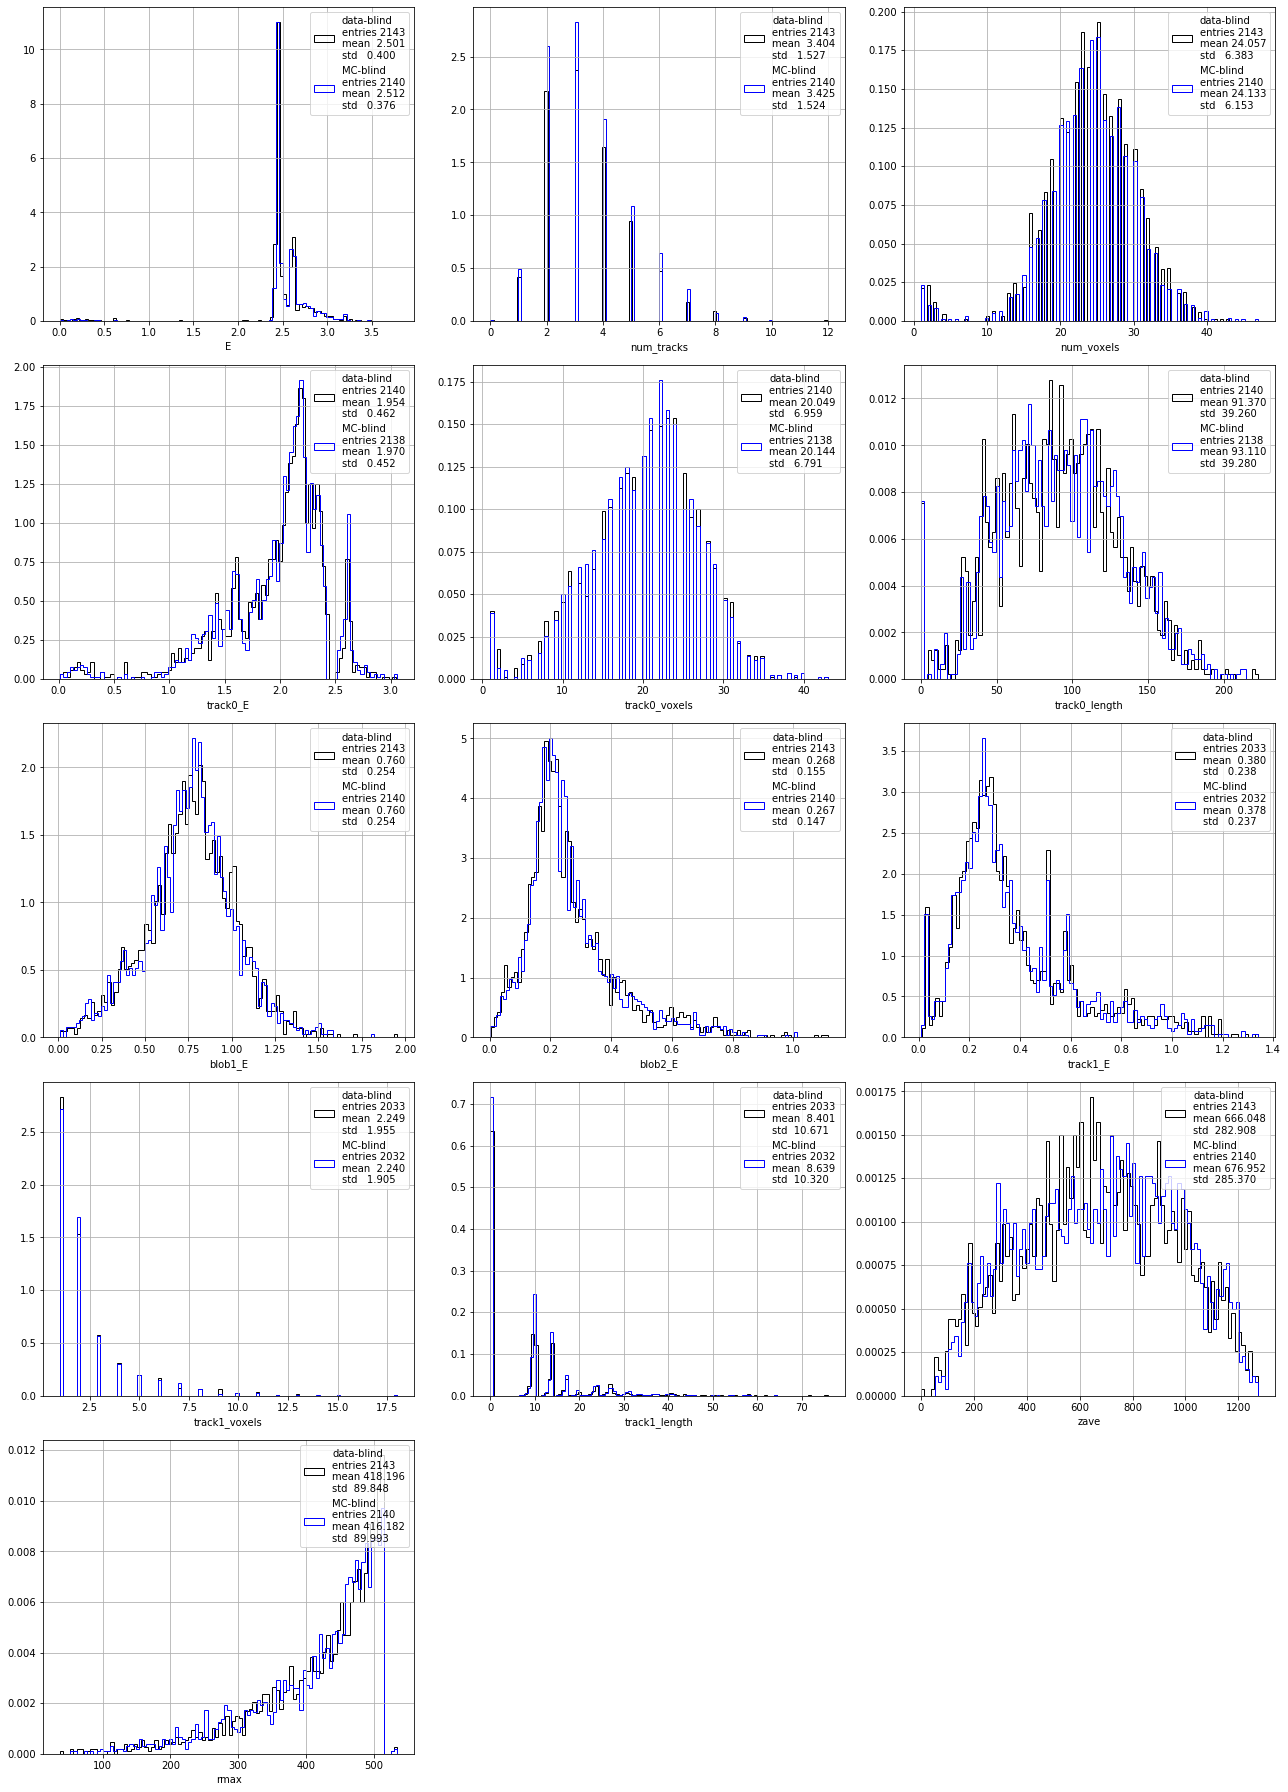

In [20]:
pltext.dfs_inspect((datab, mcblind), dfnames = ('data-blind', 'MC-blind'), ncolumns = 3);

### Verify the efficiencies of the selection

 efficiencies :  0.7802 +- 0.0089,  0.0285 +- 0.0036,  0.0061 +- 0.0017,  0.0000 +- 0.0000, 
 efficiencies :  0.7841 +- 0.0089,  0.0285 +- 0.0036,  0.0033 +- 0.0012,  0.0000 +- 0.0000, 


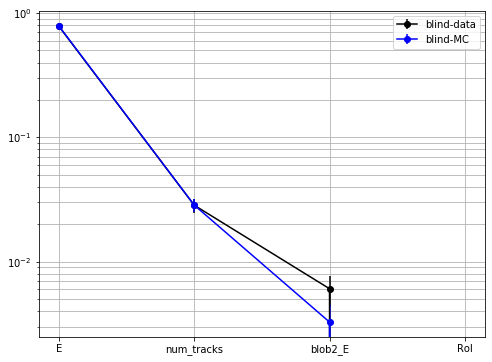

In [21]:
subplot = pltext.canvas(1, 1, 6, 8)
subplot(1)
dfnames = ['blind-data', 'blind-MC']
for i, df in enumerate([datab, mcblind]):
    eff, ueff = fn.efficiencies(df)
    print(' efficiencies : ', *['{0:6.4f} +- {1:6.4f}, '.format(ieff, iueff) for ieff, iueff in zip(eff, ueff)])
    plt.errorbar(range(4), eff, yerr = ueff, marker = 'o', label = dfnames[i])
plt.yscale('log'); plt.xticks(range(4), fn.keys); 
plt.grid(which = 'both'); plt.legend();